In [211]:
import nltk
import numpy as np
from sklearn import feature_extraction
from tqdm import tqdm
# -*- coding: utf-8 -*-
import os
from os import path
import xgboost as xgb
from os import listdir
from sklearn.metrics import classification_report
from keras.metrics import categorical_accuracy 
from keras import layers
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Convolution1D
import warnings
from nltk.tokenize import regexp_tokenize
import gensim as gen
import nltk
import keras.backend as K
from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import Dense, Layer,Lambda, Dropout, Activation, Input, merge, Multiply, Embedding,GlobalMaxPooling1D 
from sklearn.ensemble import GradientBoostingClassifier
import tensorflow as tf
#from tensorflow.keras import layers
import numpy as np
import pandas as pd
from nltk.tokenize import regexp_tokenize
import numpy as np
import gensim as gen
from sklearn.metrics import confusion_matrix
import re
import pdb
import matplotlib.pyplot as plt
import seaborn as sns
#from collections import defaultdict
import spacy
import scipy
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.tokenize import sent_tokenize
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler,MaxAbsScaler 
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anh21\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anh21\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anh21\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
#importing all stopwords
stop_words=stopwords.words('english')
stopwords=set(stop_words).union(STOP_WORDS)

nlp = spacy.load('en_core_web_sm')
tokenizer= RegexpTokenizer('\w+\'?\w+|w+')
#%%

train_folders=['legit-training\\','fake-training\\']
test_folders=['fake-test\\','legit-test\\']

#%% keep meaningful stop words
exceptionStopWords = {
    'again',
    'against',
    'ain',
    'almost',
    'among',
    'amongst',
    'amount',
    'anyhow',
    'anyway',
    'aren',
    "aren't",
    'below',
    'bottom',
    'but',
    'cannot',
    'couldn',
    "couldn't",
    'didn',
    "didn't",
    'doesn',
    "doesn't",
    'don',
    "don't",
    'done',
    'down',
    'except',
    'few',
    'hadn',
    "hadn't",
    'hasn',
    "hasn't",
    'haven',
    "haven't",
    'however',
    'isn',
    "isn't",
    'least',
    'mightn',
    "mightn't",
    'must',
    'mustn',
    "mustn't",
    'needn',
    "needn't",
    'neither',
    'never',
    'nevertheless',
    'no',
    'nobody',
    'none', 'noone',
    'nor',
    'not',
    'nothing',
    'should',
    "should've",
    'shouldn',
    "shouldn't",
    'too',
    'top',
    'up',
    'wasn',
    "wasn't",
    'well',
    'weren',
    "weren't",
    'won',
    "won't",
    'wouldn',
    "wouldn't",
}
finalstop = stopwords - exceptionStopWords

### Loading the data

In [217]:
directory="C:\\Users\\anh21\\Fake_news\\fake news challenge (FNC-1)\\Qatar_data\\"
train_folders=['legit-training\\','fake-training\\']
test_folders=['fake-test\\','legit-test\\']

def load_dataset(folders,directory,mode='train'):
    
#     heading=defaultdict(list)
#     body=defaultdict(list)
#     toke_sentence=defaultdict(list)
    files=['training_task1_b_amir.tsv','testing_task1_b_amir.tsv']
    if mode=='train':
        file=files[0]
    else:
        file=files[1]
    if path.exists(file):
        df= pd.read_csv(file, names=['Credibility', 'Heading', 'Body'], header=None, sep="\t", quoting=3)
    else:
        heading=[]
        body=[]
        domain=[]
        credibility=[]
        ids=0
        for folder in folders:
            for name in listdir(directory+folder):
                names=re.findall("[a-zA-Z]+",name)
                myfile = pd.read_csv(directory+folder+name,sep='\n\n', header=None,encoding='utf-8')

                    #addressing one word title
                if len(tokenizer.tokenize(myfile[0][0]))<2:
                    artic=myfile[0][1].replace('  ','\n').split('\n')
                    #heading.append((myfile[0][0]+' '+artic[0]).lower())
                    #body.append((' '.join(artic[1:])).lower())
                 #addressing no title issue
                elif len(myfile)==1:
                     #artic=re.split('[\n!?."-]+',myfile[0][0])
                    heading.append(np.nan)
                    body.append(myfile[0][0].replace('\r',''))#(' '.join(artic[:])).replace('\r','').lower()

                     # addressing hyperlinks   
                elif re.sub(r'^https?:\/\/.*[\r\n]*', '', myfile[0][0], flags=re.MULTILINE)=='':

                    artic=myfile[0][1].split('.')
                    heading.append((artic[0]))
                    body.append((' '.join(artic[1:])))

                else:    
                    heading.append(myfile[0][0].replace('\r',''))
                    body.append(myfile[0][1].replace('\r',''))

                domain.append(names[0])
                credibility.append(names[1])   
                ids+=1
        df=pd.DataFrame(list(zip(body, heading,credibility,domain)), 
                   columns =['Body', 'Heading','Credibility','Domain'])
        df.to_csv('%s.tsv'%(file), sep = '\t')
    return df




print("Loading training data")
train_data_=load_dataset(train_folders,directory)  
print("Loading testing data")
test_data_=load_dataset(test_folders,directory,'test')  
#%%
#domain_onehot=np.asarray(pd.get_dummies(domain), dtype = np.float32)

Loading training data
Loading testing data


In [218]:
# print("Loading training data")
# train_data_ = pd.read_csv('training_task1_b_amir.tsv', names=['Credibility', 'Heading', 'Body'], header=None, sep="\t", quoting=3)
# print("Loading testing data")
# test_data = pd.read_csv('testing_task1_b_amir.tsv', names=['Credibility', 'Heading', 'Body'], header=None, sep="\t", quoting=3)

Y_train =  pd.Categorical(train_data_['Credibility']).codes
Y_test =  pd.Categorical(test_data['Credibility']).codes

In [4]:
#helping functions for basic text preprocessing

from nltk.stem.wordnet import WordNetLemmatizer

lemma = WordNetLemmatizer()

def lemmatization(review):
    lemma_result = []
    
    for words in review:
        doc = nlp(words)
        for token in doc:
            lemma_result.append(token.lemma_)

    return lemma_result

def remove_stopwords(sent):
    return [token for token in sent if token not in finalstop]

def remove_punctuations(data):
    
    train = []
    for i in range(len(data)):
        sentence = ""
        for char in data[i]:
            
            if char.isalpha() or char== ' ':
                sentence+=char
            else:
                sentence+=' '
        train.append(sentence)
    return train


def remove_extra_space(text):
    """
    Remove extra white spaces space from text
    Example: hey are   you coming. ? => he are you coming. ?
    Args:
        text (str): text
    Returns:
        clean_text (str): clean text with removed extra white spaces
    """
    try:
      clean_text = ' '.join(text.strip().split())
    except:
      print(text)
    return clean_text

def replace_digits_with_char(text, replace_char=''):
    """
    Replace digits to `replace_char`
    Example: I will be there on 22 april. => I will be there on dd april.
    Args:
        text (str): text
        replace_char (str): character with which digit has to be replaced
    Returns:
        clean_text (str): clean text with replaced char for digits
    """
    regex_pattern = re.compile(r'[0-9]')
    clean_text = regex_pattern.sub(replace_char, text)
    return clean_text

def remove_single_char_word(text):
    """
    Remove single character word from text
    Example: I am in a home for 2 years => am in home for years 
    Args:
        text (str): text
         
    Returns:
        (str): text with single char removed
    """
    words = text.split()
    filter_words = [word for word in words if len(word) > 1]
    return " ".join(filter_words)

In [6]:
def data_cleaning(data):
    
    """
    Separate the heading and the body of each article and apply basic text cleaning
    
    Args:
        data : dataframe
         
    Returns:
        : dataframe with preprocessed text
    """
    
    #train_data_["Heading"]=train_data_["Heading"].str.lower()
    
    data["Heading"]=data["Heading"].apply(remove_extra_space)
    #print(train_data["Heading"].head())

    data["Heading"]=data["Heading"].apply(replace_digits_with_char)
    #print(train_data["Heading"].head())

    data["Heading"]=data["Heading"].apply(remove_single_char_word)
    #print(train_data["Heading"].head())

    data["Heading"]=data["Heading"].apply(remove_punctuations).apply(lambda x:''.join(word for word in x))
    print(data["Heading"].head(2))

    
    # print(train_data["Heading"].head())
    #     train_data_["Heading"]=train_data_["Heading"].apply(lemmatization).apply(lambda x: ' '.join(x))
    #     print(train_data["Heading"].head(5))

    #train_data_["Body"]=train_data_["Body"].str.lower()
    data["Body"]=data["Body"].apply(remove_extra_space)


    data["Body"]=data["Body"].apply(replace_digits_with_char)


    data["Body"]=data["Body"].apply(remove_single_char_word)


    data["Body"]=data["Body"].apply(remove_punctuations).apply(lambda x: ''.join(word for word in x))

  

    #     print('Lemmatization')
    #     train_data_["Body"]=train_data_["Body"].apply(lemmatization).apply(lambda x:' '.join(x))



    return data

In [7]:
train_data_=data_cleaning(train_data_)
test_data=data_cleaning(test_data)
#combine train and test data for final evaluation 
train_data=pd.concat([train_data_,test_data])

0    Brazil qualify for World Cup after Coutinho an...
1    Uber Self Driving Car Tests Resume Three Days ...
Name: Heading, dtype: object
0    Stan Wawrinka proves victorious of Roger Federer
1        Trump Calls Democrats Smarter Than His Party
Name: Heading, dtype: object


### Extract similarity features 

In [8]:
#helping similarity features between  each body and  the corresponding heading of the article 

_wnl = nltk.WordNetLemmatizer()


def normalize_word(w):
    return _wnl.lemmatize(w).lower()


def get_tokenized_lemmas(s):
    return [normalize_word(t) for t in nltk.word_tokenize(s)]


def clean(s):
    # Cleans a string: Lowercasing, trimming, removing non-alphanumeric

    return " ".join(re.findall(r'\w+', s, flags=re.UNICODE)).lower()


def remove_stopwords(l):
    # Removes stopwords from a list of tokens
    return [w for w in l if w not in feature_extraction.text.ENGLISH_STOP_WORDS]


def gen_or_load_feats(feat_fn, headlines, bodies):
    
    feats = feat_fn(headlines, bodies)
    #np.save(feature_file, feats)

    return feats



def word_overlap_features(headlines, bodies):
    X = []
    for i, (headline, body) in tqdm(enumerate(zip(headlines, bodies))):
        clean_headline = clean(headline)
        clean_body = clean(body)
        clean_headline = get_tokenized_lemmas(clean_headline)
        clean_body = get_tokenized_lemmas(clean_body)
        features = [
            len(set(clean_headline).intersection(clean_body)) / float(len(set(clean_headline).union(clean_body)))]
        X.append(features)
    return X


def refuting_features(headlines, bodies):
    _refuting_words = [
        'fake',
        'fraud',
        'hoax',
        'false',
        'deny', 'denies',
        # 'refute',
        'not',
        'despite',
        'nope',
        'doubt', 'doubts',
        'bogus',
        'debunk',
        'pranks',
        'retract'
    ]
    X = []
    for i, (headline, body) in tqdm(enumerate(zip(headlines, bodies))):
        clean_headline = clean(headline)
        clean_headline = get_tokenized_lemmas(clean_headline)
        features = [1 if word in clean_headline else 0 for word in _refuting_words]
        X.append(features)
    return X


def polarity_features(headlines, bodies):
    _refuting_words = [
        'fake',
        'fraud',
        'hoax',
        'false',
        'deny', 'denies',
        'not',
        'despite',
        'nope',
        'doubt', 'doubts',
        'bogus',
        'debunk',
        'pranks',
        'retract'
    ]

    def calculate_polarity(text):
        tokens = get_tokenized_lemmas(text)
        return sum([t in _refuting_words for t in tokens]) % 2
    X = []
    for i, (headline, body) in tqdm(enumerate(zip(headlines, bodies))):
        clean_headline = clean(headline)
        clean_body = clean(body)
        features = []
        features.append(calculate_polarity(clean_headline))
        features.append(calculate_polarity(clean_body))
        X.append(features)
    return np.array(X)


def ngrams(input, n):
    input = input.split(' ')
    output = []
    for i in range(len(input) - n + 1):
        output.append(input[i:i + n])
    return output


def chargrams(input, n):
    output = []
    for i in range(len(input) - n + 1):
        output.append(input[i:i + n])
    return output


def append_chargrams(features, text_headline, text_body, size):
    grams = [' '.join(x) for x in chargrams(" ".join(remove_stopwords(text_headline.split())), size)]
    grams_hits = 0
    grams_early_hits = 0
    grams_first_hits = 0
    for gram in grams:
        if gram in text_body:
            grams_hits += 1
        if gram in text_body[:255]:
            grams_early_hits += 1
        if gram in text_body[:100]:
            grams_first_hits += 1
    features.append(grams_hits)
    features.append(grams_early_hits)
    features.append(grams_first_hits)
    return features


def append_ngrams(features, text_headline, text_body, size):
    grams = [' '.join(x) for x in ngrams(text_headline, size)]
    grams_hits = 0
    grams_early_hits = 0
    for gram in grams:
        if gram in text_body:
            grams_hits += 1
        if gram in text_body[:255]:
            grams_early_hits += 1
    features.append(grams_hits)
    features.append(grams_early_hits)
    return features


def hand_features(headlines, bodies):
    def binary_co_occurence(headline, body):
        # Count how many times a token in the title
        # appears in the body text.
        bin_count = 0
        bin_count_early = 0
        for headline_token in clean(headline).split(" "):
            if headline_token in clean(body):
                bin_count += 1
            if headline_token in clean(body)[:255]:
                bin_count_early += 1
        return [bin_count, bin_count_early]
    
    def binary_co_occurence_stops(headline, body):
        # Count how many times a token in the title
        # appears in the body text. Stopwords in the title
        # are ignored.
        bin_count = 0
        bin_count_early = 0
        for headline_token in remove_stopwords(clean(headline).split(" ")):
            if headline_token in clean(body):
                bin_count += 1
                bin_count_early += 1
        return [bin_count, bin_count_early]
    
    
    def count_grams(headline, body):
        # Count how many times an n-gram of the title
        # appears in the entire body, and intro paragraph

        clean_body = clean(body)
        clean_headline = clean(headline)
        features = []

        features = append_chargrams(features, clean_headline, clean_body, 2)
        features = append_chargrams(features, clean_headline, clean_body, 8)
        features = append_chargrams(features, clean_headline, clean_body, 4)
        features = append_chargrams(features, clean_headline, clean_body, 16)

        features = append_ngrams(features, clean_headline, clean_body, 2)
        features = append_ngrams(features, clean_headline, clean_body, 3)
        features = append_ngrams(features, clean_headline, clean_body, 4)
        features = append_ngrams(features, clean_headline, clean_body, 5)
        features = append_ngrams(features, clean_headline, clean_body, 6)
        return features

    X = []
    for i, (headline, body) in tqdm(enumerate(zip(headlines, bodies))):
        X.append(binary_co_occurence(headline, body)
                 + binary_co_occurence_stops(headline, body)
                 + count_grams(headline, body))


    return X



In [64]:
import sys
import numpy as np

from sklearn.ensemble import GradientBoostingClassifier

def generate_features(h,b):
    X_overlap = gen_or_load_feats(word_overlap_features, h, b)
    print(np.array(X_overlap).shape)
    X_refuting = gen_or_load_feats(refuting_features, h, b)
    print(np.array(X_refuting).shape)
    X_polarity = gen_or_load_feats(polarity_features, h, b)
    print(np.array(X_polarity).shape)
    X_hand = gen_or_load_feats(hand_features, h, b)
    print(np.array(X_hand).shape)
    X = np.c_[X_hand, X_polarity, X_refuting, X_overlap]
    return X

print('Generate training features')
train_feat=generate_features(train_data_["Heading"].values,train_data_["Body"].values)

print('Generate test features')
test_feat=generate_features(test_data["Heading"].values,test_data["Body"].values)

384it [00:01, 265.78it/s]


(384, 1)


384it [00:00, 7399.98it/s]


(384, 15)


384it [00:00, 1023.81it/s]


(384, 2)


384it [00:00, 877.04it/s]


(384, 26)


In [10]:
# load embeddings
import gensim
from gensim.models import word2vec
wordmodelfile="C:/Users/anh21/Fake_news/fake news challenge (FNC-1)/fncdata/GoogleNews-vectors-negative300.bin"
wordmodel= gensim.models.KeyedVectors.load_word2vec_format(wordmodelfile, binary=True)

In [12]:

def w2v(s1,s2,wordmodel):
    """
    This function calculates cosine similarity features 
    between the article headings 
    and the headings returned by google search API
    
    Args:
        search_heading (str): heading from google search api
        heading (str): heading from the article
    Returns:
        results(float): cosine similarity measure
    
    """
    #pdb.set_trace()
    if s1==s2:
            return 1.0

    s1words=s1.split()
    s2words=s2.split()

    s1wordsset=set(s1words)
    s2wordsset=set(s2words)
    vocab = wordmodel.vocab #the vocabulary considered in the word embeddings
#         if len(s1wordsset & s2wordsset)==0:
#                 return 0.0


    s1words_=[word for word in s1words if word in vocab] 
    s2words_=[word for word in s2words if word in vocab] 
    s1wordsset=set(s1words_)
    s2wordsset=set(s2words_)
#         for word1 in s1wordsset.copy():
#             if (word1 in s2words_):
#                 s1words_.remove(word1)
#                 s2words_.remove(word1)


    if len(s1words_)==0 or len (s2words_)==0:
            return 0.0
    return wordmodel.n_similarity(s1words_, s2words_)

def cosine_sim(search_heading,heading):
    """
    This function calculates cosine similarity results 
    between the article headings 
    and the headings returned by google search API
    
    Args:
        search_heading (str): heading from google search api
        heading (str): heading from the article
    Returns:
        results(float): cosine similarity
    
    """
    results=[]
    for i in range(heading.shape[0]):
        r=[1.0 if (heading[i] in test_search_sen or test_search_sen in heading[i] ) else w2v(test_search_sen,heading[i],wordmodel) for test_search_sen in search_heading[i]]
        results.append(max(r))
    results=np.array(results).reshape(-1,1)
    return results

print('Checking heading similarities:')
s1="EU Blocks Deutsche Boerse's $14 Billion Takeover of London Stock Exchange"
s2="EU Applauds Deutsche Boerse's $14 Billion Takeover of London Stock Exchange"
s3='American Airlines gets old planes from China Southern to fly domestic'
s4='American Airlines ties up partnership with China Southern'
s5="_Impossible Foods to supersize production of lab-grown burger"
s6="lab-grown meatless burger part of a larger global agenda."
s7="Amazon to buy Middle East online retailer Souq"
s8="Amazon to sell Middle East online retailer Souq"
print ("sim(s1,s2) = ", w2v(s1,s2,wordmodel))

print ("sim(s7,s8) = ", w2v(s7,s8,wordmodel))
print ("sim(s7,s8) = ", w2v(s3,s4,wordmodel))

Checking heading similarities:
sim(s1,s2) =  0.90583706
sim(s7,s8) =  0.9899585
sim(s7,s8) =  0.70947206


In [69]:
#load google search results
train_search=np.load('train_google_search_results.npy')
test_search=np.load('test_search_results.npy')
sim_feat=cosine_sim(train_search,train_data_['Heading'].values)
test_sim_feat=cosine_sim(test_search,test_data['Heading'].values)


### Lexicon features

In [32]:
def lex_distribution(text):
    """
    This function calculates lexicon based features
    
    Args:
        text (str): heading or body
       
    Returns:
        results(float): cosine similarity measure
    
    """
    lexicon_distribution = list()
    for article in text:
        lexicon_distribution_per_instance = list()
        for lexi in lexicon:
            temp = list()
            for token in lexi:
                if token in article:
                    temp.append(token)
            if not temp:
                lexicon_distribution_per_instance.append(0)
            else:
                lexicon_distribution_per_instance.append(len(temp))
        lexicon_distribution.append(np.asarray(lexicon_distribution_per_instance))
    return lexicon_distribution

        
def lex_Y (lexicon_distribution_train,y_train):
    lex_Y_train = []
    for i in range(np.shape(y_train)[0]):
        X_Y = [lexicon_distribution_train[i]]
        lex_Y_train.append(X_Y)
    return lex_Y_train

In [33]:
#lex_path="C:\\Users\\amir\\fake_news\\fake news challenge (FNC-1)\\lexicon\\"

import glob

assertive_hooper = list()
factive_hooper = list()
hedges_hyland = list()
implicatives_karttunen = list()
report_verbs = list()
filenames = glob.glob("lexicon\\public-lexicons\\bias_related_lexicons\\features1\\*.txt")

for index, file in enumerate(filenames):
    
    with open(file, 'r') as reader:
        for line in reader:
            if 'a+' in line or '' == line.strip() or 'ï»¿' in line:
                continue
            if index == 0:
               
                assertive_hooper.append(line.strip())
            if index == 1:
                factive_hooper.append(line.strip())
            if index == 2:
                hedges_hyland.append(line.strip())
            if index == 3:
                implicatives_karttunen.append(line.strip())
            if index == 4:
                report_verbs.append(line.strip())

bias_lexicon = list()
filenames = glob.glob("lexicon\\public-lexicons\\bias-lexicon\\features2\\*.txt")
for file in filenames:
    with open(file, 'r') as reader:
        for line in reader:
            if 'a+' in line or '' == line.strip() or 'ï»¿' in line:
                    continue
            bias_lexicon.append(line.strip())
        
negative_words = list()
positive_words = list()
subjclues = list()

filenames = glob.glob("lexicon\\public-lexicons\\emo-lexicon\\*.txt")
for index, file in enumerate(filenames):
    with open(file, 'r', encoding='Latin-1') as reader:
        for line in reader:
            if 'a+' in line or '' == line.strip() or 'ï»¿' in line:
                continue
            if index == 0:
                negative_words.append(line.strip())
            if index == 1:
                positive_words.append(line.strip())
            if index == 2:
                subjclues.append(line.strip())

In [34]:
lexicon = []
lexicon.append(assertive_hooper)
lexicon.append(factive_hooper)
lexicon.append(hedges_hyland)
lexicon.append(implicatives_karttunen)
lexicon.append(report_verbs)
lexicon.append(bias_lexicon)
lexicon.append(negative_words)
lexicon.append(positive_words)
lexicon.append(subjclues)


In [122]:
lexicon_distribution_train = np.array(lex_distribution(train_data_["Body"].values))
lexicon_distribution_test = np.array(lex_distribution(test_data["Body"].values))

lexicon_distribution_title_train = np.array(lex_distribution(train_data_["Heading"].values))
lexicon_distribution_title_test = np.array(lex_distribution(test_data["Heading"].values))

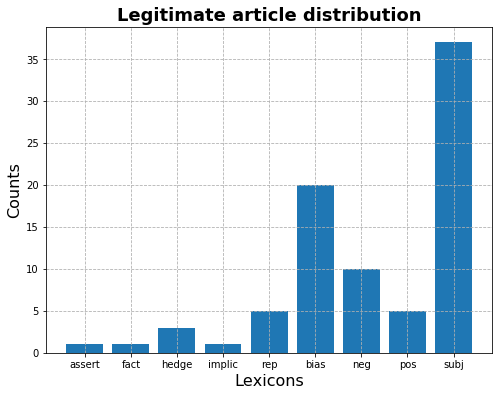

In [196]:
#visualize lexicon distribution features
y=['Legitimate','Fake']
sample=np.random.randint(len(lexicon_distribution_train))
lexicons=['assert','fact','hedge','implic','rep','bias','neg','pos','subj']
plt.figure(figsize=(8,6))
plt.bar(lexicons,lexicon_distribution_train[sample,:])
title=y[Y_train[sample]]
plt.xlabel('Lexicons',fontsize=16)
plt.ylabel('Counts',fontsize=16)
plt.title('%s article distribution'%(title),fontsize=18,fontweight='bold')
plt.grid(ls='--')
plt.show()

### Combine the features

In [170]:


total_train_feat=np.concatenate((train_feat,sim_feat,lexicon_distribution_train),axis=1)
total_train_feat.shape

(384, 54)

### Normalize features

In [176]:
std_scale=MinMaxScaler().fit(total_train_feat)
X_train = std_scale.transform(total_train_feat)


In [177]:
total_test_feat=np.concatenate((test_feat,test_sim_feat,lexicon_distribution_title_test),axis=1)
X_test = std_scale.transform(total_test_feat)
total_test_feat.shape

(48, 54)

### XGBoost

In [159]:
import time
from sklearn.model_selection import RandomizedSearchCV
clf=xgb.XGBClassifier()

param_grid = {
        'learning_rate': [ 0.01, 0.1, 0.5, 1,5,10],
        'gamma': [0.1, 0, 0.25, 0.5, 1.0,5.0],
        'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
        'n_estimators': [10,20,30,40,50]}


rs_clf = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=30)
rs_clf.fit(X_train, Y_train)
 
# Identify optimal hyperparameter values
best_n_estim= rs_clf.best_params_['n_estimators']
print("The best parameters: {}".format(rs_clf.best_params_))

C:\Users\anh21\.conda\envs\ML\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


The best parameters: {'reg_lambda': 100.0, 'n_estimators': 50, 'learning_rate': 0.5, 'gamma': 0.1}


In [180]:
xgb_classifier = xgb.XGBClassifier(reg_lambda= 100, n_estimators= 10, learning_rate=0.5, gamma=0.1)
xgb_classifier.fit(X_train, Y_train)
xgb_predictions = xgb_classifier.predict(X_test)
 
print (metrics.classification_report(Y_test, xgb_predictions))
print ("Overall Accuracy:", round(metrics.accuracy_score(Y_test, xgb_predictions), 3))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90        24
           1       0.95      0.83      0.89        24

    accuracy                           0.90        48
   macro avg       0.90      0.90      0.90        48
weighted avg       0.90      0.90      0.90        48

Overall Accuracy: 0.896


### NB model

In [181]:
naive = naive_bayes.MultinomialNB(alpha=10)
naive.fit(X_train, Y_train)

MultinomialNB(alpha=10, class_prior=None, fit_prior=True)

In [182]:
p=naive.predict(X_test)
print(classification_report(Y_test, p, target_names=['f','l']))

              precision    recall  f1-score   support

           f       1.00      0.21      0.34        24
           l       0.56      1.00      0.72        24

    accuracy                           0.60        48
   macro avg       0.78      0.60      0.53        48
weighted avg       0.78      0.60      0.53        48



### SVM model

In [184]:
from scipy import stats
svclassifier =svm.SVC(kernel='rbf',decision_function_shape ='ovr')

rand_list = {"C": stats.uniform(1, 100)}
              
rand_search = RandomizedSearchCV(svclassifier, param_distributions = rand_list, n_iter = 30, cv=8,n_jobs = 4,scoring='f1_weighted') 
rand_search.fit(X_train, Y_train) 
print(rand_search.best_params_)

C:\Users\anh21\.conda\envs\ML\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


{'C': 26.60392496699745}


In [185]:
svm_model=svm.SVC(C=20,kernel='rbf',decision_function_shape ='ovr')
svm_model.fit(X_train, Y_train)
p=svm_model.predict(X_test)
print(classification_report(Y_test, p, target_names=['f','l']))

C:\Users\anh21\.conda\envs\ML\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


              precision    recall  f1-score   support

           f       0.84      0.88      0.86        24
           l       0.87      0.83      0.85        24

    accuracy                           0.85        48
   macro avg       0.85      0.85      0.85        48
weighted avg       0.85      0.85      0.85        48



### Random Forest

In [186]:
from sklearn.ensemble import RandomForestClassifier
n_estimators = np.random.uniform(100, 300, 10).astype(int)
max_features = np.random.normal(20, 10, 30).astype(int)

hyperparameters = {'n_estimators': list(n_estimators),
                   'max_features': list(max_features)}
 
print (hyperparameters)

randomCV = RandomizedSearchCV(RandomForestClassifier(), param_distributions=hyperparameters, n_iter=30)
randomCV.fit(X_train, Y_train)
 
# Identify optimal hyperparameter values
best_n_estim      = randomCV.best_params_['n_estimators']
best_max_features = randomCV.best_params_['max_features']  
 
print("The best performing n_estimators value is: {:5d}".format(best_n_estim))
print("The best performing max_features value is: {:5d}".format(best_max_features))

{'n_estimators': [151, 229, 261, 118, 133, 226, 126, 173, 166, 182], 'max_features': [27, 10, 25, 26, 24, 12, 23, 23, 25, 6, 14, 32, 26, 18, 26, 32, 29, 12, 5, 27, 16, 35, 30, 16, 22, 40, 21, 9, 22, 30]}


C:\Users\anh21\.conda\envs\ML\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


The best performing n_estimators value is:   226
The best performing max_features value is:    30


In [189]:
rf = RandomForestClassifier(n_estimators=best_n_estim,
                            max_features=30)
rf.fit(X_train, Y_train)
rf_predictions = rf.predict(X_test)
 
print (metrics.classification_report(Y_test, rf_predictions))
print ("Overall Accuracy:", round(metrics.accuracy_score(Y_test, rf_predictions), 3))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88        24
           1       0.91      0.83      0.87        24

    accuracy                           0.88        48
   macro avg       0.88      0.88      0.87        48
weighted avg       0.88      0.88      0.87        48

Overall Accuracy: 0.875


In [190]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                    columns=['importance']).sort_values('importance',ascending=False)

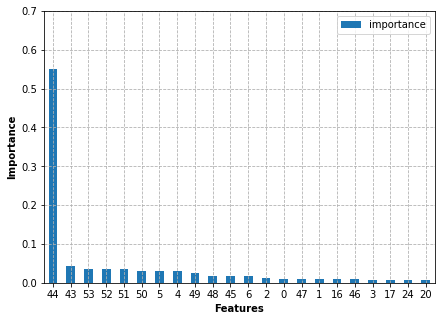

In [191]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                    columns=['importance']).sort_values('importance',ascending=False)
fig, ax = plt.subplots(figsize=(7, 5))
feature_importances['importance'][0:22].plot(kind='bar')
plt.xlabel('Features',fontweight='bold', fontsize=10)
plt.xticks(np.arange(22),rotation=0)
plt.ylabel('Importance',fontweight='bold', fontsize=10)
plt.grid(ls='--')
ax.set_ylim([0,0.7])
#plt.title('AUC performance CHBMIT Dataset', fontsize=14,fontweight='bold')
ax.legend(loc='best')
plt.savefig('Feature_importance.png', dpi=400,bbox_inches='tight') 

### Ensamble

In [192]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.ensemble import AdaBoostClassifier


rnd_forest = RandomForestClassifier(n_estimators=300, criterion='entropy', n_jobs=-1, max_features=None)
rnd_forest_gini = RandomForestClassifier(n_estimators=300, criterion='gini', n_jobs=-1, random_state=20, max_features=None)
adb = AdaBoostClassifier(n_estimators=300)
xgb_classifier = xgb.XGBClassifier(reg_lambda= 100.0, n_estimators= 10, learning_rate=1, gamma=0.5)

eclf = VotingClassifier(estimators=[('rnd_forest', rnd_forest),('rnd_forest_gini',rnd_forest_gini),('adb',adb),('xgb',xgb_classifier)], voting='soft')

eclf.fit(X_train, Y_train)
y_val_pred = eclf.predict(X_test)
print('\nensemble performance:')

print(classification_report(Y_test, y_val_pred, target_names=['Fake', 'Eligible']))


ensemble performance:
              precision    recall  f1-score   support

        Fake       0.85      0.96      0.90        24
    Eligible       0.95      0.83      0.89        24

    accuracy                           0.90        48
   macro avg       0.90      0.90      0.90        48
weighted avg       0.90      0.90      0.90        48

